<a href="https://colab.research.google.com/github/yejikwon7/AI/blob/main/CNN-hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [103]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

# torchvision.datasets에 MNIST 등의 다양한 데이터를 사용하기 위해 용이하게 정리
import torchvision.datasets as dset   # data set 불러오기 위함

# torchvision.transforms에는 이미지 데이터를 자르거나 확대 및 다양하게 변형시키는 함수 구현
import torchvision.transforms as transforms   # 변형 작업 수행 위함

# DataLoader는 전처리가 끝난 데이터들을 지정한 배치 크기에 맞게 모아서 전달해주는 역할
from torch.utils.data import DataLoader
import numpy as np # array
import matplotlib.pyplot as plt # 그래프

print(torch.__version__)

2.5.1+cu121


In [104]:
batch_size = 256
learning_rage = 0.1
num_epoch = 20

In [105]:
# download는 데이터가 저장할 위치에 없을 경우 새로 다운받을지 여부
mnist_train = dset.MNIST("../", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
# ToTensor: conv 연산 수행하기 위함
# target_transform: label에 대한 변형
mnist_test = dset.MNIST("../", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

In [106]:
print(mnist_train.__getitem__(0)[0].size(), mnist_train.__len__())
print(mnist_test.__getitem__(0)[0].size(), mnist_test.__len__())

print(len(mnist_train), len(mnist_test))

torch.Size([1, 28, 28]) 60000
torch.Size([1, 28, 28]) 10000
60000 10000


In [107]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
# batch_size=batch_size: 배치 단위로 나눔
# shuffle: 순차적으로 구성된 data인 경우
# drop_last: 남은 data 사용할지 -> 사용X, 온전히 256개로 지정된 data만 사용
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

In [108]:
class CNN(nn.Module):
    def __init__(self, dataset='mnist', num_classes=10):
        super(CNN, self).__init__()
        if dataset == 'mnist':
            input_shape = (1, 28, 28)
        else:
            raise ValueError("Unsupported dataset. Provide input_shape manually for custom datasets.")

        # Convolutional layers
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=input_shape[0], out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.Dropout2d(0.8),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.Dropout2d(0.8),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Feature Map 크기 계산
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)  # 임시 입력 생성 (배치 크기=1)
            feature_map_size = self.layer(dummy_input).view(-1).size(0)  # 평탄화된 Feature 크기 계산

        # Fully connected layers
        self.fc_layer = nn.Sequential(
            nn.Linear(feature_map_size, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        out = self.layer(x)
        out = out.view(out.size(0), -1)
        out = self.fc_layer(out)
        return out

In [109]:
# gpu가 사용 가능한 경우에는 device를 gpu로 설정하고 불가능하면 cpu로 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 모델을 지정한 장치로 올림
# class로 선언한 모델 가져옴
# 데이터도 동일하게 올려야 함
# MNIST 데이터셋 사용
model = CNN(dataset='mnist', num_classes=10).to(device)

# 모델 확인
print(model)

# 손실함수는 크로스엔트로피 사용
loss_func = nn.CrossEntropyLoss()

# 최적화 함수
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rage)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rage)

cuda:0
CNN(
  (layer): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=800, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)


In [110]:
loss_arr = []
for i in range(num_epoch):
    for j, [image, label] in enumerate(train_loader): # iteration
    # j: 배치 몇 번째인지
        x = image.to(device)
        y_ = label.to(device)

        optimizer.zero_grad()
        output = model.forward(x) # 순전파
        loss = loss_func(output, y_) # 손실값
        loss.backward() # backpropagation, 기울기 구함
        optimizer.step() # 최적화

        if j % 1000 == 0: # 1000 iteration마다
            print(loss)
            loss_arr.append(loss.cpu().detach().numpy())

tensor(2.3033, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2836, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0912, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0843, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0730, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0818, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0650, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0251, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0358, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0455, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0139, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0178, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0257, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0108, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0071, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0374, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0212, device='cuda:0', grad_fn=

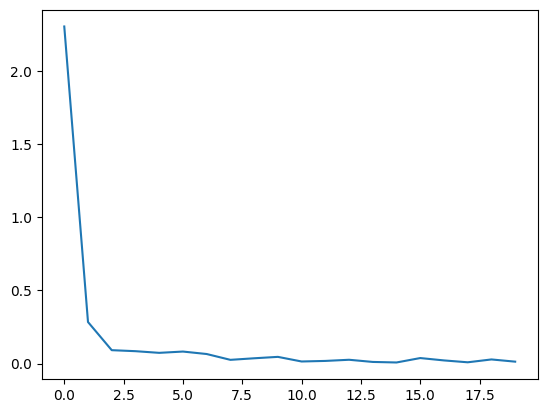

In [111]:
plt.plot(loss_arr)
plt.show()

In [112]:
# 맞은 개수, 전체 개수를 저장할 변수를 지정
correct = 0 # 예측값 = 실제값
total = 0 # 개수 달라질 수 있으므로

# 인퍼런스 모드를 위해 no_grad 함
# test에선 기울기 계산X
with torch.no_grad():
    # 테스트로더에서 이미지와 정답 불러옴
    for image, label in test_loader:
        # 두 데이터 모두 장치에 올림
        x = image.to(device)
        y_ = label.to(device)

        # 모델에 데이터 넣고 결과값 얻음
        output = model.forward(x) # 예측값: 확률값으로 나옴

        # 최댓값은 필요없으므로 인덱스만 사용
        _, output_index = torch.max(output, 1) # 확률 가장 높은 인덱스 찾아옴
        # _: 가장 큰 값 = 확률값 -> 날림

        # 전체 개수는 라벨의 개수로 더함
        # 전체 개수를 알고 있음에도 batch_size, drop_last 영향으로 데이터 잘릴 수 있으므로 수행
        total += label.size(0)

        # 모델 결과의 최댓값 인덱스와 라벨이 일치하는 개수를 correct에 더함
        correct += (output_index == y_).sum().float()

    # 테스트 데이터 전체에 대해 위의 작업을 시행 후 정확도 구함
    print("Accuracy of Test Data: {}".format(100*correct/total))

Accuracy of Test Data: 99.04847717285156
